### Analysis of Hubway Trip Time to Bike Rentral Request in Boston

This project uses data from the City of Bostom to compare Hubway bike rental metrics (number of bike rentals per hour, rental duration, etc.) against weather data for each of the Hubway station. We set out to achieve the following:

1) Determine if correlations between weather variables (temperarure, humidity, etc.) and Hubway bike rental metrics (number of Hubway bike rental requests, average trip time, number of Hibway bike rental request per hour) exist. Does the Hubway have more registered users than casual users? What variables most influence the number of Hubway bike rental per hour?

2) Determine if there is a statistically significant difference between northern and southern community areas in bike rental duration or the number of number of bike rental per hour. Perform k-means clustering to discover if census data can accurately predict a northern or southern community area.

3) Create regression model using machine learning to predict trip time and number of bike rental per hour given weather data for a particular area. This model could be used to predict the bike demand in the city for any hubway station and provide an estimate of bike inventory to be maintained for any season.

In [1]:
%pylab inline

import re
import numpy as np
import pandas as pd
import time
from time import mktime
from datetime import date, datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
import seaborn as sns
import calendar
sns.set_style(style='white')
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)

# 1 = spring, 2 = summer, 3 = fall, 4 = winter
seasons = [(4, (date(Y,  1,  1),  date(Y,  3, 20))),
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),
           (4, (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

print(get_season(date.today()))

4


In [3]:
weather = ['Clear', 'Rain', 'Rain , Thunderstorm', 'Fog , Rain',
       'Thunderstorm', 'Fog', 'Fog , Rain , Thunderstorm', 'Rain , Snow',
       'Rain , Hail , Thunderstorm', 'Snow']

#1. Clear, Clouds
#2. Mist, Drizzle, Fog
#3. Rain, Haze
#4. Snow, Thunderstorm, Squall
        
def getWeather(event):
    if (event == "Clear" or event == "Clouds"):
        return 1
    elif (event == "Mist" or event == "Drizzle" or event == 'Fog'):
        return 2
    elif (event == "Rain" or event == 'Haze'):
        return 3
    elif (event == "Snow" or event == 'Thunderstorm' or event == 'Squall'):
        return 4
    else:
        return 1
    
getWeather('Fog ')

1

In [4]:
import math

#def getWindchill(vTemperature,vWindSpeed,vRelativeHumidity):
def getWindchill(data):
    #vTemperature = float(35)
    #vWindSpeed = float(10)
    #vRelativeHumidity = float(72)
    
    vTemperature = data['TEMP']
    vWindSpeed = data['SPEED']
    vRelativeHumidity = data['HUMIDITY']
    
    # Try Wind Chill first
    if vTemperature <= 50 and vWindSpeed >= 3:
        vFeelsLike = 35.74 + (0.6215*vTemperature) - 35.75*(vWindSpeed**0.16) + ((0.4275*vTemperature)*(vWindSpeed**0.16))
    else:
        vFeelsLike = vTemperature

    # Replace it with the Heat Index, if necessary
    if vFeelsLike == vTemperature and vTemperature >= 80:
        vFeelsLike = 0.5 * (vTemperature + 61.0 + ((vTemperature-68.0)*1.2) + (vRelativeHumidity*0.094))

        if vFeelsLike >= 80:
            vFeelsLike = -42.379 + 2.04901523*vTemperature + 10.14333127*vRelativeHumidity - .22475541*vTemperature*vRelativeHumidity - .00683783*vTemperature*vTemperature - .05481717*vRelativeHumidity*vRelativeHumidity + .00122874*vTemperature*vTemperature*vRelativeHumidity + .00085282*vTemperature*vRelativeHumidity*vRelativeHumidity - .00000199*vTemperature*vTemperature*vRelativeHumidity*vRelativeHumidity
            if vRelativeHumidity < 13 and vTemperature >= 80 and vTemperature <= 112:
                vFeelsLike = vFeelsLike - ((13-vRelativeHumidity)/4)*math.sqrt((17-math.fabs(vTemperature-95.))/17)
            if vRelativeHumidity > 85 and vTemperature >= 80 and vTemperature <= 87:
                vFeelsLike = vFeelsLike + ((vRelativeHumidity-85)/10) * ((87-vTemperature)/5)
    
    #print("Feels like: " + '%0.1f' % (vFeelsLike) + "F")
    return vFeelsLike
    # Feels like: 27.4F

#getWindchill(80, 6, 80)

In [5]:
def getLattitude(station):
    dfStation = pd.read_csv('data/hubway_stations.csv') #,index_col='id')
    dfStation.columns = ['SST','TRN','STN','MNC','LAT','LNG','STA']
    return dfStation[dfStation['SST'] == station][['LAT']]

getLattitude(5)

,LAT
2,42.341814


In [6]:
def getLongitude(station):
    dfStation = pd.read_csv('data/hubway_stations.csv') #,index_col='id')
    dfStation.columns = ['SST','TRN','STN','MNC','LAT','LNG','STA']
    return dfStation[dfStation['SST'] == station][['LNG']]

getLongitude(5)

,LNG
2,-71.090179


In [7]:
def getAge(birth_year):
    now  = datetime.now()
    if birth_year != 0:
        return now.year - birth_year
    else:
        return 0

getAge(1980)

37

In [8]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [9]:
def getFahrenheit(K):
    F = (1.8*(K - 273.15)) + 32
    return round(F,0)

getFahrenheit(300)

80.0

### Hypothesis Generation

Here are some of the hypothesis which I thought could influence the demand of bikes:

* Hourly trend: There must be high demand during office timings. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.
* Daily Trend: Registered users demand more bike on weekdays as compared to weekend or holiday.
* Rain: The demand of bikes will be lower on a rainy day as compared to a sunny day. Similarly, higher humidity will cause to lower the demand and vice versa.
* Temperature: In India, temperature has negative correlation with bike demand. But, after looking at Washington’s temperature graph, I presume it may have positive correlation.
* Pollution: If the pollution level in a city starts soaring, people may start using Bike (it may be influenced by government / company policies or increased awareness).
* Traffic: It can be positively correlated with Bike demand. Higher traffic may force people to use bike as compared to other road transport medium like car, taxi etc

### Importing Data set and Basic Data Exploration

#### Importing Hubway trip data from csv

Link to dataset: http://hubwaydatachallenge.org/trip-history-data/

In [10]:
df1 = pd.read_csv('data/hubway_trips.csv',parse_dates=True, index_col='seq_id', na_values={''})

df1.columns = ['HID','STATUS','DURATION','START_DATE','START_STATION','END_DATE',
                   'END_STATION','BIKE_NO','SUB_TYPE','ZIPCODE','BIRTH_DATE','GENDER']

#### Cleaning the dataset

In [11]:
dfTrips = df1.copy()

#Convert completion date from string to datetime object
cleanedStartDate = []
for date in dfTrips['START_DATE']:
    if date != None:
        cleanedStartDate.append(datetime.strptime(date, '%m/%d/%Y %H:%M:%S'))
    else:
        cleanedStartDate.append(None)

del dfTrips['START_DATE'], dfTrips['END_DATE']#, dfTrips['BIKE_NO'], dfTrips['ZIPCODE']

dfTrips.insert(1, 'START_DATE', cleanedStartDate)
#dfTrips['START_DATE'] = dfTrips.START_DATE.dt.round('H')
#dfTrips.insert(2, 'DATE', dfTrips['START_DATE'].apply(lambda x: x.date()))
dfTrips.insert(3, 'YEAR', dfTrips['START_DATE'].dt.year)
dfTrips['BIKE_NO']  = dfTrips['BIKE_NO'].fillna('').astype(str)

dfTrips.head(5)

,HID,START_DATE,STATUS,YEAR,DURATION,START_STATION,END_STATION,BIKE_NO,SUB_TYPE,ZIPCODE,BIRTH_DATE,GENDER
seq_id,,,,,,,,,,,,
1,8,2011-07-28 10:12:00,Closed,2011,9,23.0,23.0,B00468,Registered,'97217,1976.0,Male
2,9,2011-07-28 10:21:00,Closed,2011,220,23.0,23.0,B00554,Registered,'02215,1966.0,Male
3,10,2011-07-28 10:33:00,Closed,2011,56,23.0,23.0,B00456,Registered,'02108,1943.0,Male
4,11,2011-07-28 10:35:00,Closed,2011,64,23.0,23.0,B00554,Registered,'02116,1981.0,Female
5,12,2011-07-28 10:37:00,Closed,2011,12,23.0,23.0,B00554,Registered,'97214,1983.0,Female


##### Timeseries plot of HUbway Trip Data

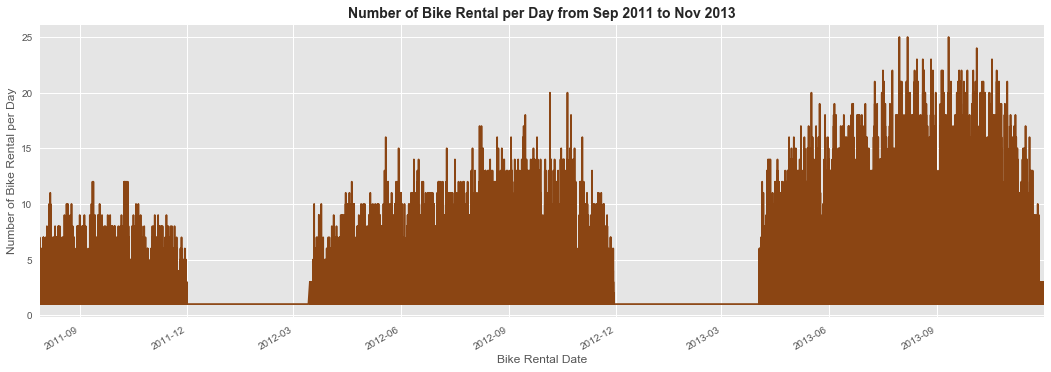

In [12]:
rentalByDate = dfTrips.groupby('START_DATE')['START_DATE'].count()
fig = plt.figure(figsize=(18, 6))
rentalByDate.plot(color = 'saddlebrown')
#plt.xlim([datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2013, 12, 31, 0, 0)])
#plt.ylim([0,30])
plt.ylabel('Number of Bike Rental per Day', fontsize = 12)
plt.xlabel('Bike Rental Date', fontsize = 12)
plt.title('Number of Bike Rental per Day from Sep 2011 to Nov 2013', fontsize = 14, fontweight = 'bold');

plt.show()

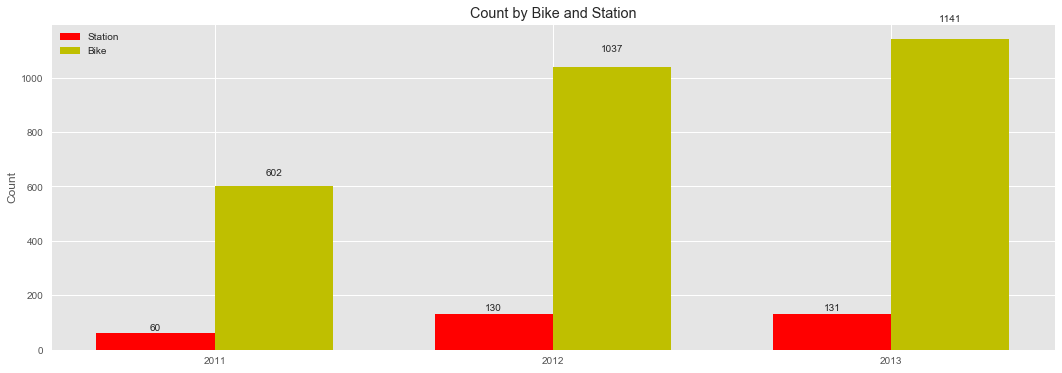

In [13]:
import numpy as np
import matplotlib.pyplot as plt

cnt1 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2011][['START_STATION']]))
cnt2 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2012][['START_STATION']]))
cnt3 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2013][['START_STATION']]))

cnt4 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2011][['BIKE_NO']]))
cnt5 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2012][['BIKE_NO']]))
cnt6 = np.count_nonzero(unique(dfTrips[dfTrips['YEAR'] == 2013][['BIKE_NO']]))

N = 3
station_cnt = (cnt1, cnt2, cnt3)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(18, 6))
rects1 = ax.bar(ind, station_cnt, width, color='r')

bike_cnt = (cnt4, cnt5, cnt6)

rects2 = ax.bar(ind + width, bike_cnt, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_title('Count by Bike and Station')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('2011', '2012', '2013'))

ax.legend((rects1[0], rects2[0]), ('Station', 'Bike'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

#### Importing Daily Weather Data from csv

In [14]:
df21 = pd.read_csv('data/dailyweather.csv',parse_dates=True)

#### Cleaning the dataset

In [15]:
df21.columns = ['CDATE','YEAR','MONTH','DAY','THIGH','TAVG','TLOW','DHIGH','DAVG',
               'DLOW','HHIGH','HAVG','HLOW','PHIGH','PAVG','PLOW','VHIGH','VAVG',
               'VLOW','WHIGH','WAVG','WLOW','PRECIP','EVENT']

dfDailyWeather = df21.copy()

cleanedDate = []
for date in dfDailyWeather['CDATE']:
    if date != None:
        cleanedDate.append(datetime.strptime(date, '%m/%d/%Y'))
    else:
        cleanedDate.append(None)

dfDailyWeather.insert(1, 'DATE', cleanedDate)
dfDailyWeather['DATE'] = dfDailyWeather['DATE'].apply(lambda x: x.date())

dfDailyWeather[['EVENT']] = dfDailyWeather[['EVENT']].fillna(value='Clear')
dfDailyWeather['PRECIP']  = pd.to_numeric(dfDailyWeather['PRECIP'], errors='ignore')
dfDailyWeather['PRECIP']  = dfDailyWeather['PRECIP'].str.replace('T', '0').astype(np.float64)

del dfDailyWeather['YEAR'], dfDailyWeather['MONTH'], dfDailyWeather['DAY'], dfDailyWeather['THIGH']
del dfDailyWeather['TLOW'], dfDailyWeather['DHIGH'], dfDailyWeather['DLOW'], dfDailyWeather['HHIGH']
del dfDailyWeather['HLOW'], dfDailyWeather['PHIGH'], dfDailyWeather['PLOW'], dfDailyWeather['VHIGH']
del dfDailyWeather['VLOW'], dfDailyWeather['WHIGH'], dfDailyWeather['WLOW'], dfDailyWeather['CDATE']

dfDailyWeather.insert(9, 'WEATHER', dfDailyWeather['EVENT'].map(getWeather))

dfDailyWeather.head()

,DATE,TAVG,DAVG,HAVG,PAVG,VAVG,WAVG,PRECIP,EVENT,WEATHER
0,2011-01-01,46,37,73,30.04,9,6,0.00,Clear,1
1,2011-01-02,45,41,85,29.88,5,7,0.15,Rain,3
2,2011-01-03,34,12,48,29.98,10,15,0.00,Clear,1
3,2011-01-04,32,16,52,29.89,10,10,0.00,Clear,1
4,2011-01-05,34,15,49,29.73,10,12,0.00,Clear,1


##### Importing Hourly Weather Data from csv

In [16]:
df22 = pd.read_csv('data/hourlyweather.csv',parse_dates=True)

#### Cleaning the dataset

In [17]:
dfHourlyWeather = df22.copy()

cleanedDate = []
cleanedDate = pd.to_datetime(dfHourlyWeather['dt'],unit='s')

dfHourlyWeather.insert(3, 'START_DATE', cleanedDate)

tempFahrenheit = []
tempFahrenheit = dfHourlyWeather['temp'].map(getFahrenheit).astype(int)
dfHourlyWeather.insert(4, 'TEMP', tempFahrenheit)

dfHourlyWeather = dfHourlyWeather.rename(columns = {'city_id':'CITY', 
                                                    'pressure':'PRESSURE',
                                                    'humidity':'HUMIDITY',
                                                    'wind_speed':'SPEED',
                                                    'rain_1h':'RAIN',
                                                    'snow_1h':'SNOW',
                                                    'weather_main':'WEATHER'})
aTempFahrenheit = []
aTempFahrenheit = dfHourlyWeather.apply(getWindchill, axis=1)
dfHourlyWeather.insert(5, 'ATEMP', aTempFahrenheit)
dfHourlyWeather[['ATEMP']] = round(dfHourlyWeather[['ATEMP']],0).astype(int)

dfHourlyWeather[['RAIN']] = round(dfHourlyWeather[['RAIN']].fillna(value=0),1)
dfHourlyWeather[['SNOW']] = round(dfHourlyWeather[['SNOW']].fillna(value=0),1)

del dfHourlyWeather['dt'],dfHourlyWeather['temp']
del dfHourlyWeather['dt_iso'],dfHourlyWeather['city_name']
del dfHourlyWeather['lat'],dfHourlyWeather['lon'],dfHourlyWeather['PRESSURE']
del dfHourlyWeather['temp_min'],dfHourlyWeather['temp_max']
del dfHourlyWeather['sea_level'],dfHourlyWeather['grnd_level']
del dfHourlyWeather['wind_deg'],dfHourlyWeather['clouds_all']
del dfHourlyWeather['rain_3h'],dfHourlyWeather['rain_24h'],dfHourlyWeather['rain_today']
del dfHourlyWeather['snow_3h'],dfHourlyWeather['snow_24h'],dfHourlyWeather['snow_today']
del dfHourlyWeather['weather_id'],dfHourlyWeather['weather_icon'],dfHourlyWeather['weather_description']

#4183849, 4317656, 4930956
dfHourlyWeather = dfHourlyWeather[dfHourlyWeather['CITY'] == 4930956][['START_DATE','TEMP','ATEMP','HUMIDITY','SPEED','RAIN','SNOW','WEATHER']]

dfHourlyWeather.head()

,START_DATE,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,WEATHER
17754,2012-10-01 13:00:00,57,57,68,3,0.0,0.0,Clear
17755,2012-10-02 14:00:00,59,59,68,3,0.0,0.0,Clear
17756,2012-10-02 15:00:00,62,62,64,3,0.0,0.0,Clear
17757,2012-10-02 16:00:00,62,62,64,4,0.0,0.0,Clear
17758,2012-10-02 17:00:00,63,63,64,4,0.0,0.0,Clear


##### Merging Data

In [18]:
dfTrips['START_DATE'] = dfTrips.START_DATE.dt.round('H')

dfXX = pd.DataFrame(pd.pivot_table(dfTrips, index=['START_DATE'], values='DURATION', aggfunc=np.mean).to_records())
dfYY = pd.DataFrame(pd.pivot_table(dfTrips, index=['START_DATE'], columns=["SUB_TYPE"], values='HID', aggfunc='count').to_records())

dfZZ = pd.merge(dfXX, dfYY, on='START_DATE')
dfZZ = dfZZ.rename(columns = {'Casual':'CASUAL', 'Registered':'REGISTERED'})

dfHourlyRental = pd.merge(dfZZ, dfHourlyWeather, on='START_DATE')

dfHourlyRental[['CASUAL']] = dfHourlyRental[['CASUAL']].fillna(value=0).astype(int)
dfHourlyRental[['REGISTERED']] = dfHourlyRental[['REGISTERED']].fillna(value=0).astype(int)
dfHourlyRental[['DURATION']] = round(dfHourlyRental[['DURATION']]/60,0).astype(int)

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=dfHourlyRental['START_DATE'].min(), end=dfHourlyRental['START_DATE'].max()).to_pydatetime()

holiday = []
holiday = dfHourlyRental['START_DATE'].isin(holidays).astype(int)
dfHourlyRental.insert(11, 'HOLIDAY', holiday)

workday = []
workday = ((pd.DatetimeIndex(dfHourlyRental['START_DATE']).dayofweek) // 5 == 1).astype(int)
dfHourlyRental.insert(12, 'WORKDAY', workday)

month = []
month = pd.to_datetime(dfHourlyRental['START_DATE']).dt.month
dfHourlyRental.insert(13, 'MONTH', month)
dfHourlyRental['MONTH'] = dfHourlyRental['MONTH'].apply(lambda x: calendar.month_abbr[x])

weekday = []
weekday = pd.to_datetime(dfHourlyRental['START_DATE']).dt.weekday_name
dfHourlyRental.insert(14, 'WEEKDAY', weekday)

season = []
season = dfHourlyRental['START_DATE'].map(get_season)
dfHourlyRental.insert(15, 'SEASON', season)

dfHourlyRental['WEATHER'] = dfHourlyRental['WEATHER'].map(getWeather)

dfHourlyRental['TOTAL'] = dfHourlyRental['CASUAL'] + dfHourlyRental['REGISTERED']
dfHourlyRental['TOTAL'] = dfHourlyRental['TOTAL'].fillna(value=0).astype(int)

cols = ['START_DATE','SEASON','WEEKDAY','MONTH','HOLIDAY','WORKDAY','TEMP',
        'ATEMP','HUMIDITY','SPEED','RAIN','SNOW','WEATHER','DURATION','CASUAL',
        'REGISTERED','TOTAL']

dfHourlyRental = dfHourlyRental[cols]

dfHourlyRental.head(5)

,START_DATE,SEASON,WEEKDAY,MONTH,HOLIDAY,WORKDAY,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,WEATHER,DURATION,CASUAL,REGISTERED,TOTAL
0,2012-10-01 13:00:00,3,Monday,Oct,0,0,57,57,68,3,0.0,0.0,1,14,30,104,134
1,2012-10-02 14:00:00,3,Tuesday,Oct,0,0,59,59,68,3,0.0,0.0,1,12,36,94,130
2,2012-10-02 15:00:00,3,Tuesday,Oct,0,0,62,62,64,3,0.0,0.0,1,14,26,49,75
3,2012-10-02 16:00:00,3,Tuesday,Oct,0,0,62,62,64,4,0.0,0.0,1,11,17,62,79
4,2012-10-02 17:00:00,3,Tuesday,Oct,0,0,63,63,64,4,0.0,0.0,1,10,20,164,184


##### Variable Type Identification

In [19]:
dfHourlyRental.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6695
Data columns (total 17 columns):
START_DATE    6696 non-null datetime64[ns]
SEASON        6696 non-null int64
WEEKDAY       6696 non-null object
MONTH         6696 non-null object
HOLIDAY       6696 non-null int64
WORKDAY       6696 non-null int64
TEMP          6696 non-null int64
ATEMP         6696 non-null int64
HUMIDITY      6696 non-null int64
SPEED         6696 non-null int64
RAIN          6696 non-null float64
SNOW          6696 non-null float64
WEATHER       6696 non-null int64
DURATION      6696 non-null int64
CASUAL        6696 non-null int64
REGISTERED    6696 non-null int64
TOTAL         6696 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(12), object(2)
memory usage: 941.6+ KB


##### Find missing values in data set if any

In [20]:
null_data = dfHourlyRental[dfHourlyRental.isnull().any(axis=1)]
print(null_data.count)

<bound method DataFrame.count of Empty DataFrame
Columns: [START_DATE, SEASON, WEEKDAY, MONTH, HOLIDAY, WORKDAY, TEMP, ATEMP, HUMIDITY, SPEED, RAIN, SNOW, WEATHER, DURATION, CASUAL, REGISTERED, TOTAL]
Index: []>


##### Basic Data Exploration

Understand the distribution of numerical variables and generate a frequency table for numeric variables.  Now, I’ll test and plot a histogram for each numerical variables and analyze the distribution.

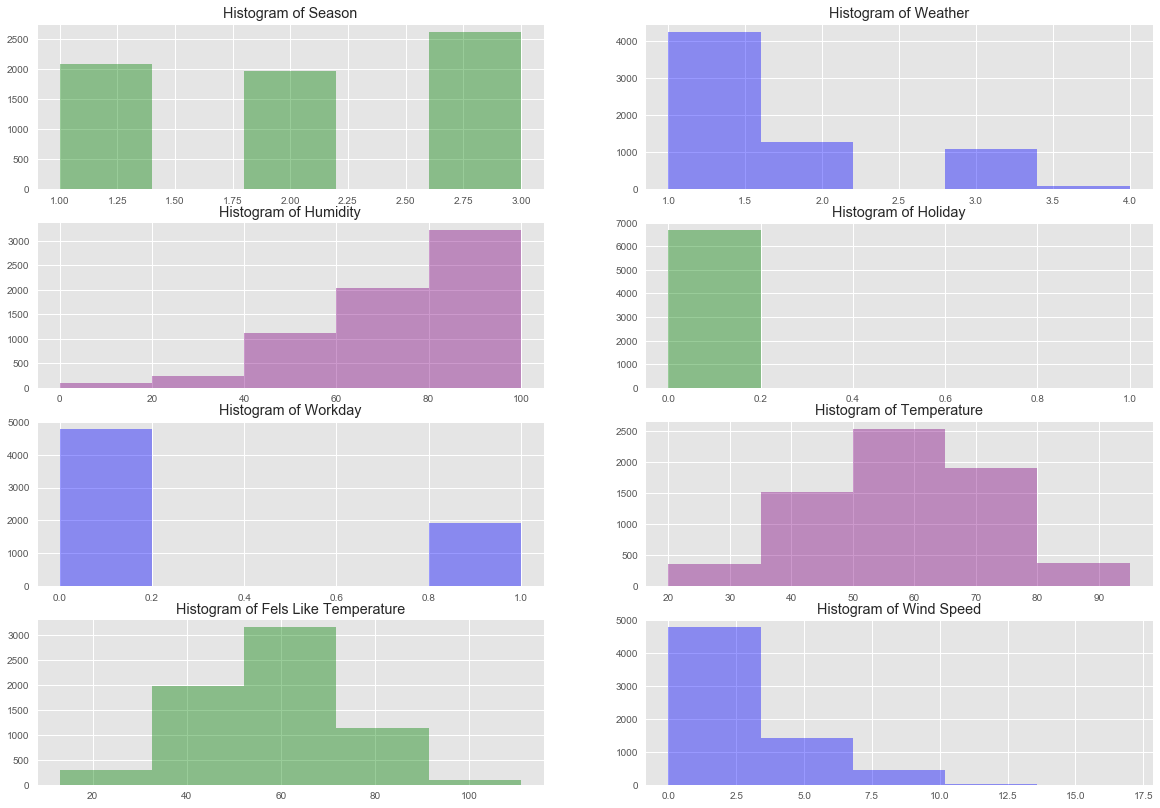

In [21]:
a = dfHourlyRental['SEASON']
b = dfHourlyRental['WEATHER']
c = dfHourlyRental['HUMIDITY']
d = dfHourlyRental['HOLIDAY']
e = dfHourlyRental['WORKDAY']
f = dfHourlyRental['TEMP']
g = dfHourlyRental['ATEMP']
h = dfHourlyRental['SPEED']

fig, ax = plt.subplots(4, 2, figsize=(20, 14))

ax[0, 0].hist(a, bins=5, histtype='bar',color="green",alpha=0.4)
ax[0, 0].set_title("Histogram of Season")

ax[0, 1].hist(b, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[0, 1].set_title("Histogram of Weather")

ax[1, 0].hist(c, bins=5, histtype='bar',color="purple",alpha=0.4)
ax[1, 0].set_title("Histogram of Humidity")

ax[1, 1].hist(d, bins=5, histtype='bar',color="green",alpha=0.4)
ax[1, 1].set_title("Histogram of Holiday")

ax[2, 0].hist(e, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[2, 0].set_title("Histogram of Workday")

ax[2, 1].hist(f, bins=5, histtype='bar',color="purple",alpha=0.4)
ax[2, 1].set_title("Histogram of Temperature")

ax[3, 0].hist(g, bins=5, histtype='bar',color="green",alpha=0.4)
ax[3, 0].set_title("Histogram of Fels Like Temperature")

ax[3, 1].hist(h, bins=5, histtype='bar',color="blue",alpha=0.4)
ax[3, 1].set_title("Histogram of Wind Speed")

plt.show()

Few inferences can be drawn by looking at these histograms:

* Season has three categories and fall has higher contribution
* Weather 1 has higher contribution i.e. mostly clear weather.
* As expected, mostly working days and variable holiday is also showing a similar inference.
* Variables temp, atemp, humidity and windspeed looks naturally distributed.

##### Convert discrete variables into factor (Weekday, Month, Season, holiday, workday, Weather)

In [22]:
categoryVariableList = ["WEEKDAY","MONTH","SEASON","HOLIDAY","WORKDAY","WEATHER"]
for var in categoryVariableList:
    dfHourlyRental[var] = dfHourlyRental[var].astype("category")

In [23]:
dfHourlyRental.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6695
Data columns (total 17 columns):
START_DATE    6696 non-null datetime64[ns]
SEASON        6696 non-null category
WEEKDAY       6696 non-null category
MONTH         6696 non-null category
HOLIDAY       6696 non-null category
WORKDAY       6696 non-null category
TEMP          6696 non-null int64
ATEMP         6696 non-null int64
HUMIDITY      6696 non-null int64
SPEED         6696 non-null int64
RAIN          6696 non-null float64
SNOW          6696 non-null float64
WEATHER       6696 non-null category
DURATION      6696 non-null int64
CASUAL        6696 non-null int64
REGISTERED    6696 non-null int64
TOTAL         6696 non-null int64
dtypes: category(6), datetime64[ns](1), float64(2), int64(8)
memory usage: 668.2 KB


##### Lets Start With Very Simple Visualization Of Variables DataType Count

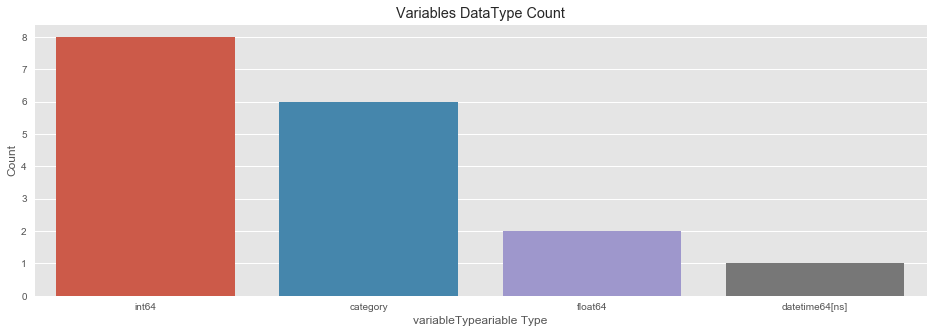

In [24]:
dataTypeDf = pd.DataFrame(dfHourlyRental.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(16,5)
sns.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

plt.show()

### Hypothesis Testing (using multivariate analysis)

##### Hourly trend: 
We don’t have the variable ‘hour’ with us right now. But we can extract it using the datetime column.

In [25]:
hour = []
hour = pd.to_datetime(dfHourlyRental['START_DATE']).dt.hour
dfHourlyRental.insert(2, 'HOUR', hour)

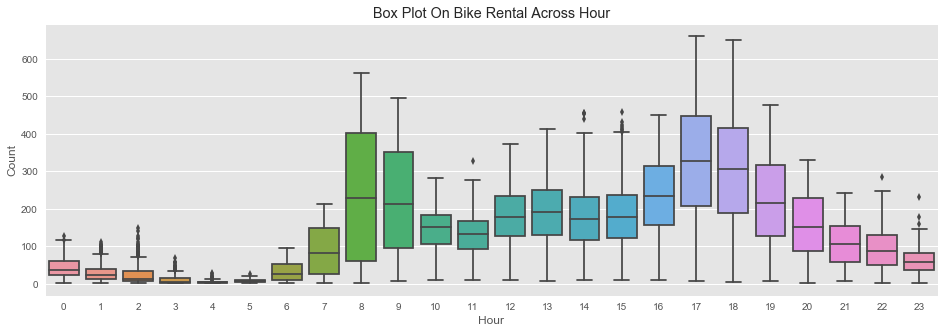

In [26]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="TOTAL",x="HOUR",orient="v",ax=axes)

axes.set(xlabel='Hour', ylabel='Count',title="Box Plot On Bike Rental Across Hour")

plt.show()

Above, we can see the trend of bike demand over hours and segregate the bike demand in three categories:

High       : 7-9 and 17-20 hours

Average  : 10-16 hours

Low         : 0-6 and 21-24 hours

Here I have analyzed the distribution of total bike demand. Let’s look at the distribution of registered and casual users separately.

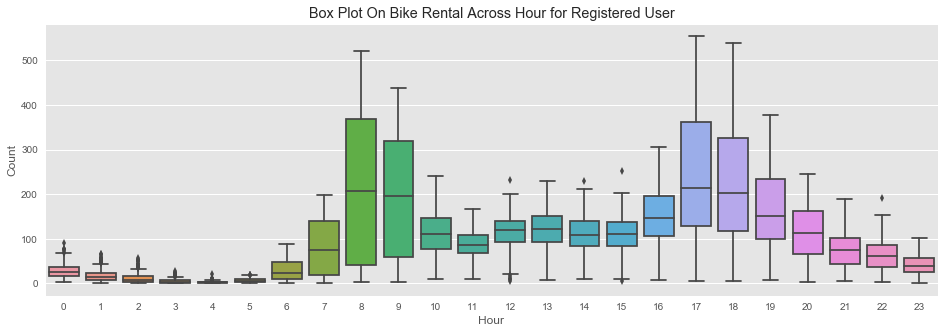

In [27]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="REGISTERED",x="HOUR",orient="v",ax=axes)

axes.set(xlabel='Hour', ylabel='Count',title="Box Plot On Bike Rental Across Hour for Registered User")

plt.show()

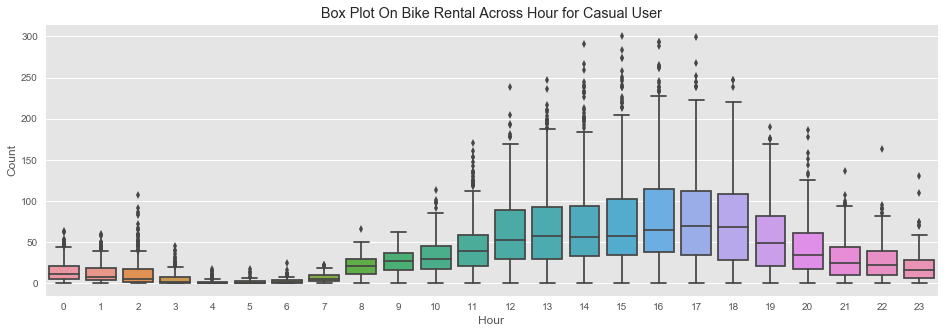

In [28]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="CASUAL",x="HOUR",orient="v",ax=axes)

axes.set(xlabel='Hour', ylabel='Count',title="Box Plot On Bike Rental Across Hour for Casual User")

plt.show()

Above we can see that registered users have similar trend as count. Whereas, casual users have different trend. Thus, we can say that ‘hour’ is significant variable and our hypothesis is ‘true’.

##### Daily Trend: 
Like Hour, we will generate a variable for day from datetime variable and after that we’ll plot it.

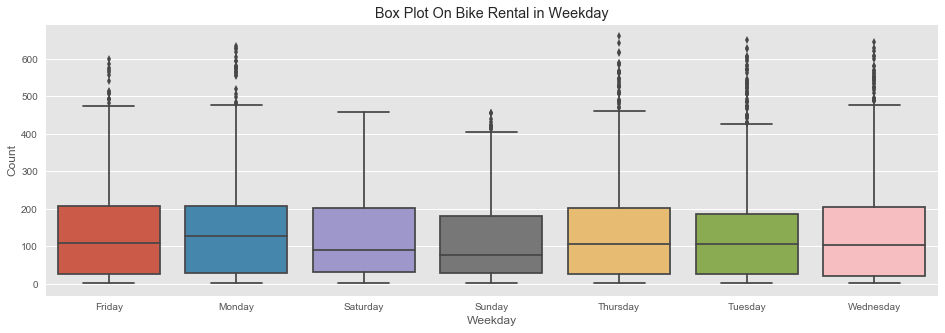

In [29]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="TOTAL",x="WEEKDAY",orient="v",ax=axes)

axes.set(xlabel='Weekday', ylabel='Count',title="Box Plot On Bike Rental in Weekday")

plt.show()

Plot shows registered and casual users’ demand over days.

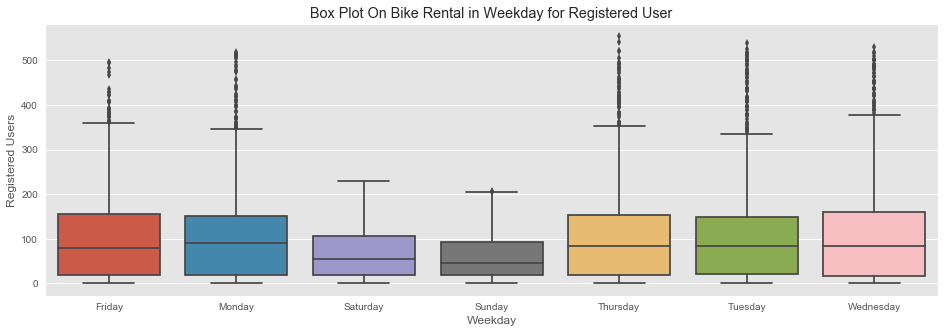

In [30]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="REGISTERED",x="WEEKDAY",orient="v",ax=axes)

axes.set(xlabel='Weekday', ylabel='Registered Users',title="Box Plot On Bike Rental in Weekday for Registered User")

plt.show()

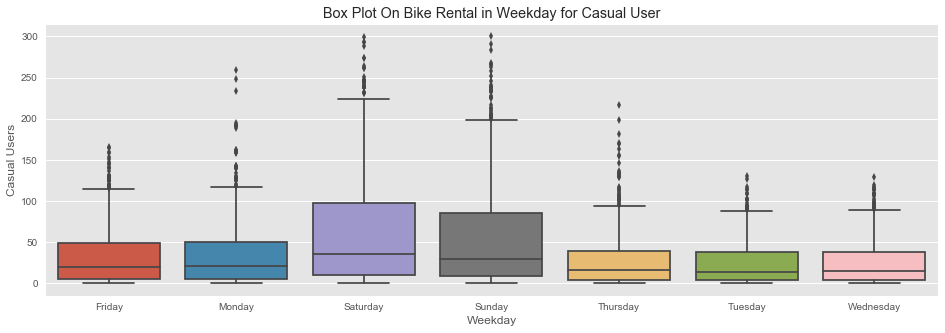

In [31]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="CASUAL",x="WEEKDAY",orient="v",ax=axes)

axes.set(xlabel='Weekday', ylabel='Casual Users',title="Box Plot On Bike Rental in Weekday for Casual User")

plt.show()

While looking at the plot, I can say that the demand of causal users increases over weekend.

##### Rain: 
We don’t have the ‘rain’ variable with us but have ‘weather’ which is sufficient to test our hypothesis. As per variable description, weather 2 represents drizzle and weather 3 represents heavy rain. Take a look at the plot:

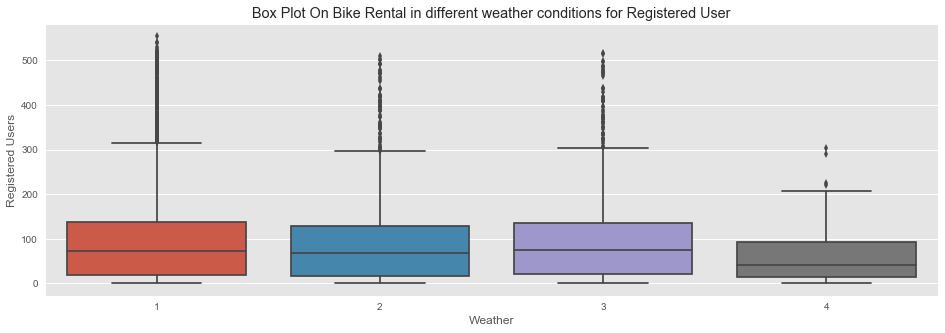

In [32]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="REGISTERED",x="WEATHER",orient="v",ax=axes)

axes.set(xlabel='Weather', ylabel='Registered Users',title="Box Plot On Bike Rental in different weather conditions for Registered User")

plt.show()

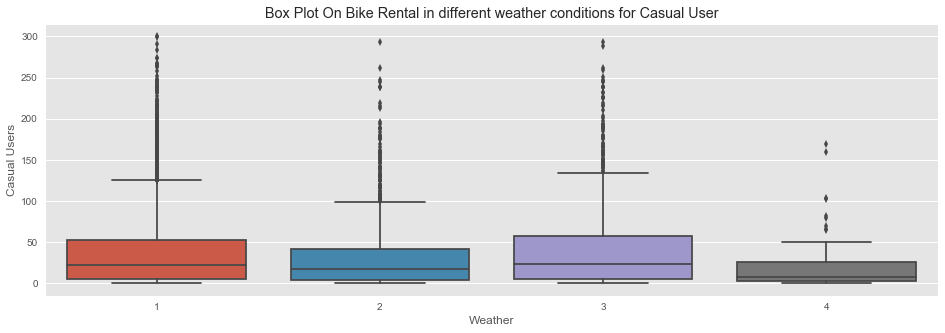

In [33]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 5)

sns.boxplot(data=dfHourlyRental,y="CASUAL",x="WEATHER",orient="v",ax=axes)

axes.set(xlabel='Weather', ylabel='Casual Users',title="Box Plot On Bike Rental in different weather conditions for Casual User")

plt.show()

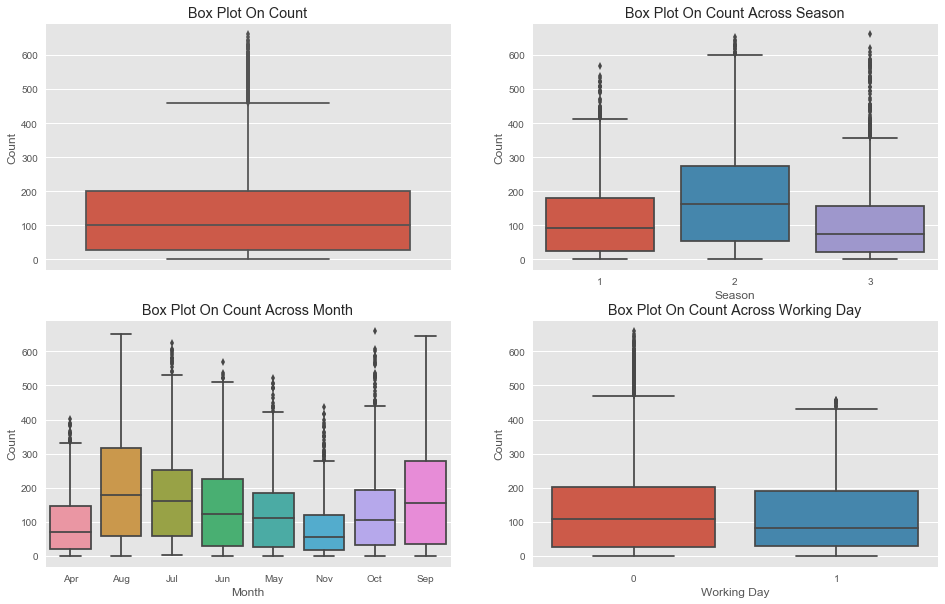

In [34]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(16, 10)
sns.boxplot(data=dfHourlyRental,y="TOTAL",orient="v",ax=axes[0][0])
sns.boxplot(data=dfHourlyRental,y="TOTAL",x="SEASON",orient="v",ax=axes[0][1])
sns.boxplot(data=dfHourlyRental,y="TOTAL",x="MONTH",orient="v",ax=axes[1][0])
sns.boxplot(data=dfHourlyRental,y="TOTAL",x="WORKDAY",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Month', ylabel='Count',title="Box Plot On Count Across Month")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

plt.show()

##### Temperature, Windspeed and Humidity: 
These are continuous variables so we can look at the correlation factor to validate hypothesis.

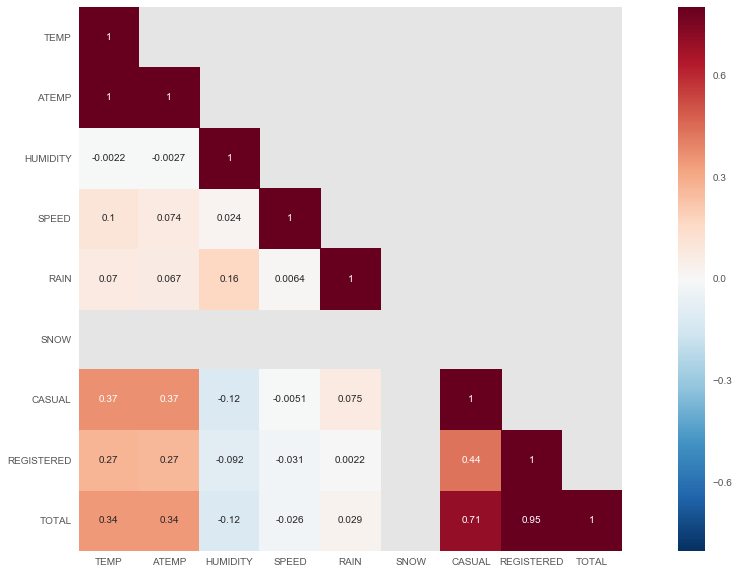

In [35]:
corrMatt = dfHourlyRental[['TEMP','ATEMP','HUMIDITY','SPEED','RAIN','SNOW','CASUAL','REGISTERED', 'TOTAL']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

plt.show()

Here are a few inferences you can draw by looking at the above histograms:

* Variable temp is positively correlated with dependent variables (casual is more compare to registered)
* Variable atemp is highly correlated with temp.
* Windspeed has lower correlation as compared to temp and humidity

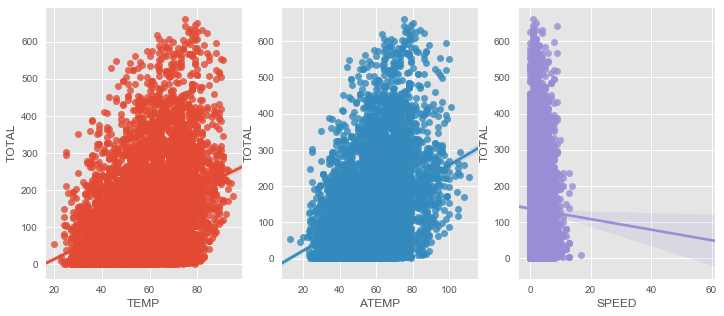

In [36]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="TEMP", y="TOTAL", data=dfHourlyRental,ax=ax1)
sns.regplot(x="ATEMP", y="TOTAL", data=dfHourlyRental,ax=ax2)
sns.regplot(x="SPEED", y="TOTAL", data=dfHourlyRental,ax=ax3)

plt.show()

##### Pollution & Traffic: 
We don’t have the variable related with these metrics in our data set so we cannot test this hypothesis.

##### Visualizing Distribution Of Data

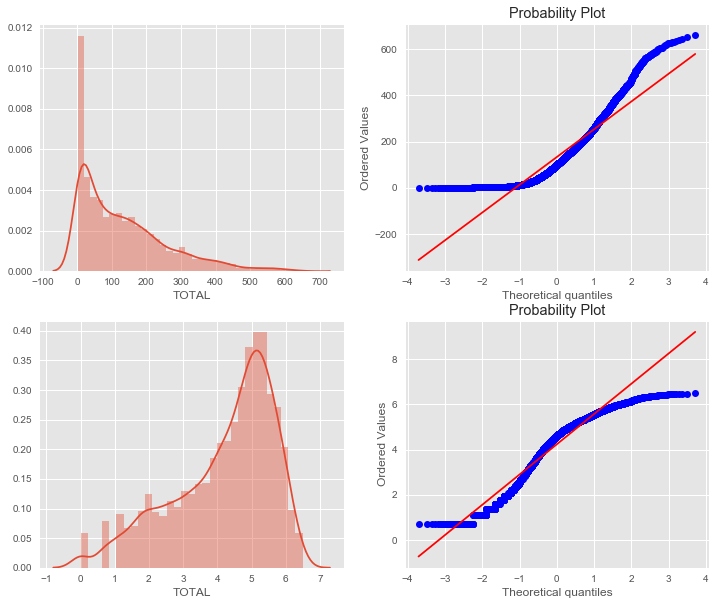

In [37]:
from scipy import stats

fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(dfHourlyRental["TOTAL"],ax=axes[0][0])
stats.probplot(dfHourlyRental["TOTAL"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(dfHourlyRental["TOTAL"]),ax=axes[1][0])
stats.probplot(np.log1p(dfHourlyRental["TOTAL"]), dist='norm', fit=True, plot=axes[1][1])
plt.show()

##### Visualizing Total Bike Rental Per Month

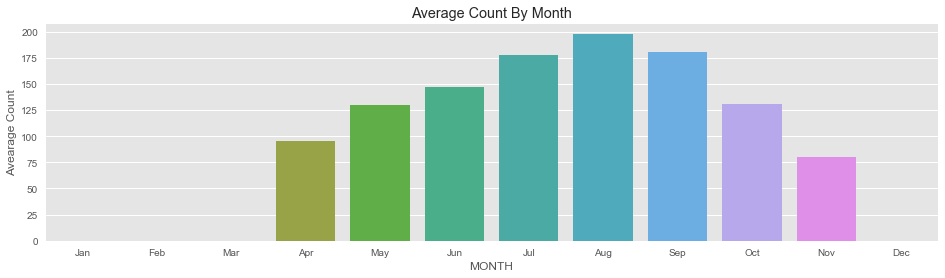

In [38]:
fig,ax1 = plt.subplots()
fig.set_size_inches(16,4)
sortOrder = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
#hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dfHourlyRental.groupby("MONTH")["TOTAL"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="TOTAL",ascending=False)
sns.barplot(data=monthSorted,x="MONTH",y="TOTAL",ax=ax1,order=sortOrder)
ax1.set(xlabel='MONTH', ylabel='Avearage Count',title="Average Count By Month")

plt.show()

### Feature Engineering

##### Dropping Unncessary Columns

In [39]:
dropFeatures = ["DURATION","CASUAL","TOTAL","START_DATE","REGISTERED"]
dfDaily  = dfHourlyRental.drop(dropFeatures,axis=1)

dfDaily.head(5)

,SEASON,HOUR,WEEKDAY,MONTH,HOLIDAY,WORKDAY,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,WEATHER
0,3,13,Monday,Oct,0,0,57,57,68,3,0.0,0.0,1
1,3,14,Tuesday,Oct,0,0,59,59,68,3,0.0,0.0,1
2,3,15,Tuesday,Oct,0,0,62,62,64,3,0.0,0.0,1
3,3,16,Tuesday,Oct,0,0,62,62,64,4,0.0,0.0,1
4,3,17,Tuesday,Oct,0,0,63,63,64,4,0.0,0.0,1


In [40]:
dfDaily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6695
Data columns (total 13 columns):
SEASON      6696 non-null category
HOUR        6696 non-null int64
WEEKDAY     6696 non-null category
MONTH       6696 non-null category
HOLIDAY     6696 non-null category
WORKDAY     6696 non-null category
TEMP        6696 non-null int64
ATEMP       6696 non-null int64
HUMIDITY    6696 non-null int64
SPEED       6696 non-null int64
RAIN        6696 non-null float64
SNOW        6696 non-null float64
WEATHER     6696 non-null category
dtypes: category(6), float64(2), int64(5)
memory usage: 779.0 KB


##### Independent Variables

* datetime:   date and hour in "mm/dd/yyyy hh:mm" format
* season:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday:    whether the day is a holiday or not (1/0)
* workingday: whether the day is neither a weekend nor holiday (1/0)
* weather:    Four Categories of weather
            1. Clear, Clouds
            2. Mist, Drizzle, Fog
            3. Rain, Haze
            4. Snow, Thunderstorm, Squall
* temp:       hourly temperature in Fahrenheit
* atemp:      "feels like" temperature in Fahrenheit
* humidity:   relative humidity
* windspeed:  wind speed

##### Dependent Variables

* Registered: number of registered user
* Casual:     number of non-registered user
* Casual:     number of total rentals (registered + casual)

In [41]:
dfRental = pd.get_dummies(dfDaily, columns=['SEASON','HOUR','WEEKDAY','MONTH','HOLIDAY','WORKDAY','WEATHER'])

dfRental.head(5)

,TEMP,ATEMP,HUMIDITY,SPEED,RAIN,SNOW,SEASON_1,SEASON_2,SEASON_3,HOUR_0,...,MONTH_Oct,MONTH_Sep,HOLIDAY_0,HOLIDAY_1,WORKDAY_0,WORKDAY_1,WEATHER_1,WEATHER_2,WEATHER_3,WEATHER_4
0,57,57,68,3,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
1,59,59,68,3,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
2,62,62,64,3,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
3,62,62,64,4,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0
4,63,63,64,4,0.0,0.0,0,0,1,0,...,1,0,1,0,1,0,1,0,0,0


In [42]:
dfRental.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6696 entries, 0 to 6695
Data columns (total 56 columns):
TEMP                 6696 non-null int64
ATEMP                6696 non-null int64
HUMIDITY             6696 non-null int64
SPEED                6696 non-null int64
RAIN                 6696 non-null float64
SNOW                 6696 non-null float64
SEASON_1             6696 non-null uint8
SEASON_2             6696 non-null uint8
SEASON_3             6696 non-null uint8
HOUR_0               6696 non-null uint8
HOUR_1               6696 non-null uint8
HOUR_2               6696 non-null uint8
HOUR_3               6696 non-null uint8
HOUR_4               6696 non-null uint8
HOUR_5               6696 non-null uint8
HOUR_6               6696 non-null uint8
HOUR_7               6696 non-null uint8
HOUR_8               6696 non-null uint8
HOUR_9               6696 non-null uint8
HOUR_10              6696 non-null uint8
HOUR_11              6696 non-null uint8
HOUR_12              6696 no

##### Linear Regression Model - Registered User

In [43]:
X = dfRental
y = dfHourlyRental['REGISTERED']

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Need to normalize due to wide variance between features
lm = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#Fit on training data
model = lm.fit(X_train, y_train)

#Look at coefficients of the model
print(pd.DataFrame(lm.coef_, index = X.columns, columns = ['estimatedCoefficients']))

                   estimatedCoefficients
TEMP                        1.412235e+00
ATEMP                      -6.147998e-01
HUMIDITY                   -1.114383e-01
SPEED                      -2.473638e+00
RAIN                        2.681859e-01
SNOW                        6.242222e+16
SEASON_1                    6.502507e+14
SEASON_2                    6.502507e+14
SEASON_3                    6.502507e+14
HOUR_0                     -2.107571e+14
HOUR_1                     -2.107571e+14
HOUR_2                     -2.107571e+14
HOUR_3                     -2.107571e+14
HOUR_4                     -2.107571e+14
HOUR_5                     -2.107571e+14
HOUR_6                     -2.107571e+14
HOUR_7                     -2.107571e+14
HOUR_8                     -2.107571e+14
HOUR_9                     -2.107571e+14
HOUR_10                    -2.107571e+14
HOUR_11                    -2.107571e+14
HOUR_12                    -2.107571e+14
HOUR_13                    -2.107571e+14
HOUR_14         

In [45]:
lm_score = round(lm.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by registered user using Linear Regression prediction {}'.format(lm_score))

Test R2 on demand for bike rental by registered user using Linear Regression prediction 0.6


In [46]:
print('MSE for training response data: {:.2f}'.format(np.mean((lm.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((lm.predict(X_test) - y_test) ** 2)))

MSE for training response data: 3720.20
MSE for test response data: 3776.83


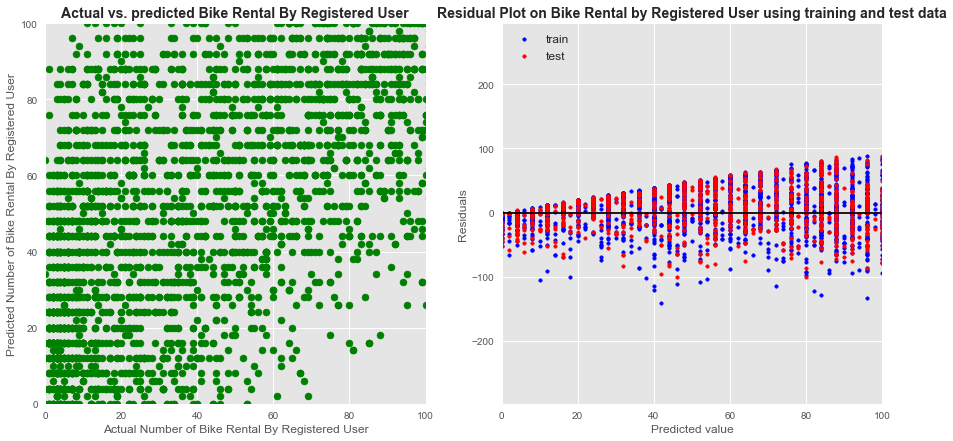

In [47]:
fig = plt.figure(figsize=(15,7))

#Plot actual vs. predicted on number of Bike Rental
plt.subplot(1,2,1)
plt.scatter(y, lm.predict(X), c='g');
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Actual Number of Bike Rental By Registered User', fontsize = 12);
plt.ylabel('Predicted Number of Bike Rental By Registered User', fontsize = 12);
plt.title('Actual vs. predicted Bike Rental By Registered User', fontsize = 14, fontweight = 'bold');

#Plot residuals of number of Bike Rental
plt.subplot(1,2,2)
plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, c='b', marker = '.', label = 'train')
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=0, xmax = 100)
plt.title('Residual Plot on Bike Rental by Registered User using training and test data', fontsize = 14, fontweight = 'bold');
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,100]);
plt.legend(fontsize = 12, loc = 2)

plt.show()

In [48]:
#Using K-folds and cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle = True)
lm_registered_cv = LinearRegression(normalize = True)

#Find MSE on response time prediction
scores = cross_val_score(lm_registered_cv, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 3813.78 
SE: 206.69


##### Random Forest Model - Registered User

In [49]:
X = dfRental
y = dfHourlyRental['REGISTERED']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf_registered = RandomForestRegressor(random_state = 0)

rf_registered.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [51]:
registered_score = round(rf_registered.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by registered user using Random Forest prediction {}'.format(registered_score))

Test R2 on demand for bike rental by registered user using Random Forest prediction 0.81


In [52]:
print('MSE for training response data: {:.2f}'.format(np.mean((rf_registered.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((rf_registered.predict(X_test) - y_test) ** 2)))

MSE for training response data: 426.87
MSE for test response data: 2138.91


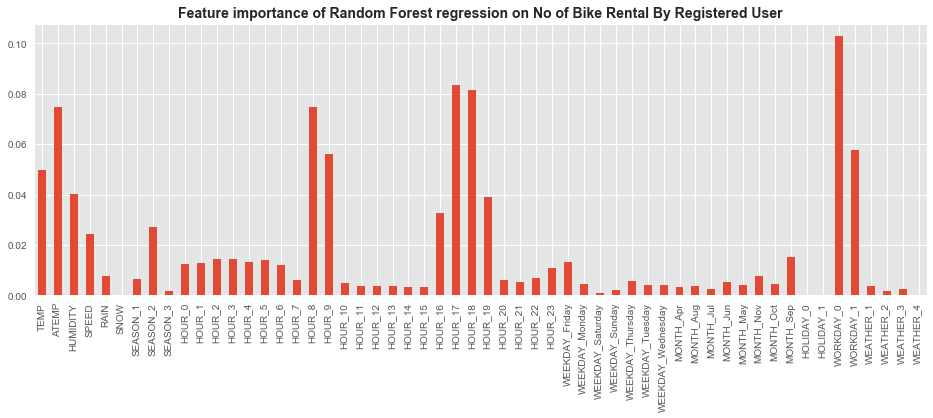

In [53]:
registered_features = pd.Series(rf_registered.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(16,5));
registered_features.plot(kind = 'bar');
plt.title('Feature importance of Random Forest regression on No of Bike Rental By Registered User', fontsize = 14, fontweight = 'bold');

In [54]:
#Find MSE on number of Bike Rental prediction using 5 K-folds for Registered User
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(5, shuffle = True)
scores = cross_val_score(rf_registered, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 2313.643801744267 
SE: 298.9485277146623


##### Gradient Boosting Model - Registered User

In [55]:
X = dfRental
y = dfHourlyRental['REGISTERED']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [56]:
import random
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gb_registered = GradientBoostingRegressor(**params).fit(X_train, y_train)

mse = mean_squared_error(y_test, gb_registered.predict(X_test))
r2 = r2_score(y_test, gb_registered.predict(X_test))

In [57]:
registered_score = round(gb_registered.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by registered user using Gradient Boosting prediction {}'.format(registered_score))

Test R2 on demand for bike rental by registered user using Gradient Boosting prediction 0.85


In [58]:
print('MSE for training response data: {:.2f}'.format(np.mean((gb_registered.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((gb_registered.predict(X_test) - y_test) ** 2)))

MSE for training response data: 242.86
MSE for test response data: 1642.80


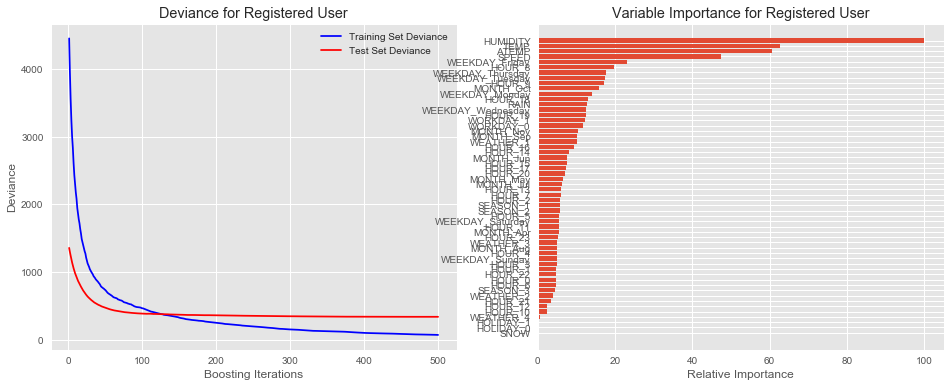

In [59]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gb_registered.staged_predict(X_test)):
    test_score[i] = gb_registered.loss_(y_test, y_pred)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance for Registered User')
plt.plot(np.arange(params['n_estimators']) + 1, gb_registered.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

feature_importance = gb_registered.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for Registered User')
plt.show()

In [60]:
#Find MSE on No Of Bike Rental prediction using 5 K-folds for Registered User
kf = KFold(5, shuffle = True)
scores = cross_val_score(gb_registered, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 1890.1261487797397 
SE: 164.7552519951984


##### Linear Regression Model - Casual User

In [61]:
X = dfRental
y = dfHourlyRental['CASUAL']

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Need to normalize due to wide variance between features
lm = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#Fit on training data
model = lm.fit(X_train, y_train)

#Look at coefficients of the model
print(pd.DataFrame(lm.coef_, index = X.columns, columns = ['estimatedCoefficients']))

                   estimatedCoefficients
TEMP                       -1.343635e+00
ATEMP                       1.410623e+00
HUMIDITY                   -2.474520e-02
SPEED                      -7.813897e-01
RAIN                        1.536406e+00
SNOW                        2.037143e+16
SEASON_1                    1.782800e+14
SEASON_2                    1.782800e+14
SEASON_3                    1.782800e+14
HOUR_0                     -6.259825e+13
HOUR_1                     -6.259825e+13
HOUR_2                     -6.259825e+13
HOUR_3                     -6.259825e+13
HOUR_4                     -6.259825e+13
HOUR_5                     -6.259825e+13
HOUR_6                     -6.259825e+13
HOUR_7                     -6.259825e+13
HOUR_8                     -6.259825e+13
HOUR_9                     -6.259825e+13
HOUR_10                    -6.259825e+13
HOUR_11                    -6.259825e+13
HOUR_12                    -6.259825e+13
HOUR_13                    -6.259825e+13
HOUR_14         

In [63]:
lm_score = round(lm.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by casual user using Linear Regression prediction {}'.format(lm_score))

Test R2 on demand for bike rental by casual user using Linear Regression prediction 0.58


In [64]:
print('MSE for training response data: {:.2f}'.format(np.mean((lm.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((lm.predict(X_test) - y_test) ** 2)))

MSE for training response data: 897.87
MSE for test response data: 830.70


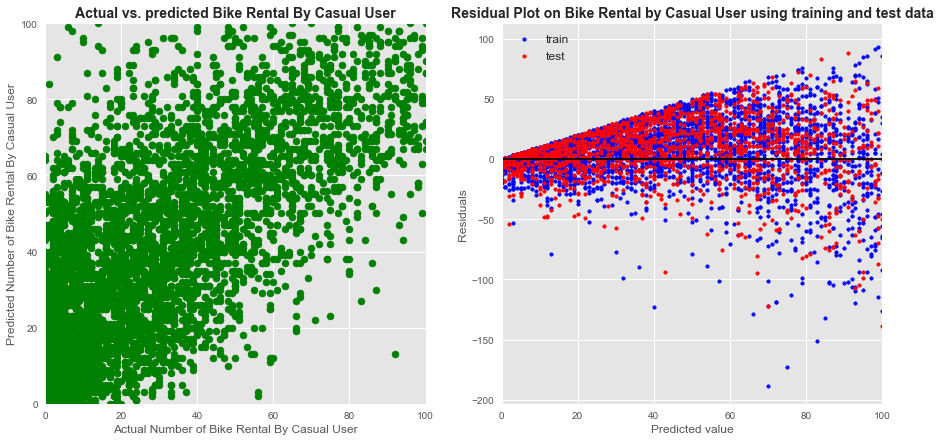

In [65]:
fig = plt.figure(figsize=(15,7))

#Plot actual vs. predicted on number of Bike Rental
plt.subplot(1,2,1)
plt.scatter(y, lm.predict(X), c='g');
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Actual Number of Bike Rental By Casual User', fontsize = 12);
plt.ylabel('Predicted Number of Bike Rental By Casual User', fontsize = 12);
plt.title('Actual vs. predicted Bike Rental By Casual User', fontsize = 14, fontweight = 'bold');

#Plot residuals of number of Bike Rental
plt.subplot(1,2,2)
plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, c='b', marker = '.', label = 'train')
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=0, xmax = 100)
plt.title('Residual Plot on Bike Rental by Casual User using training and test data', fontsize = 14, fontweight = 'bold');
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,100]);
plt.legend(fontsize = 12, loc = 2)

plt.show()

In [66]:
#Using K-folds and cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle = True)
lm_casual_cv = LinearRegression(normalize = True)

#Find MSE on number of Bike Rental prediction
scores = cross_val_score(lm_casual_cv, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 918.24 
SE: 100.55


##### Random Forest Model - Casual User

In [67]:
X = dfRental
y = dfHourlyRental['CASUAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [68]:
from sklearn.ensemble import RandomForestRegressor

rf_casual = RandomForestRegressor(random_state = 0)

rf_casual.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [69]:
casual_score = round(rf_casual.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by casual user using Random Forest prediction {}'.format(casual_score))

Test R2 on demand for bike rental by casual user using Random Forest prediction 0.76


In [70]:
print('MSE for training response data: {:.2f}'.format(np.mean((rf_casual.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((rf_casual.predict(X_test) - y_test) ** 2)))

MSE for training response data: 105.17
MSE for test response data: 536.22


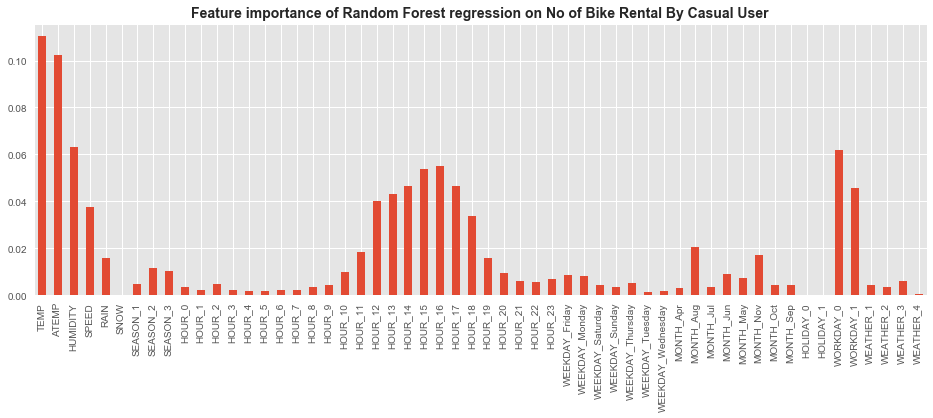

In [71]:
casual_features = pd.Series(rf_casual.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(16,5));
casual_features.plot(kind = 'bar');
plt.title('Feature importance of Random Forest regression on No of Bike Rental By Casual User', fontsize = 14, fontweight = 'bold');

In [72]:
#Find MSE on number of Bike Rental prediction using 5 K-folds for Casual User
kf = KFold(5, shuffle = True)
scores = cross_val_score(rf_casual, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 620.003747781139 
SE: 56.71011434375562


##### Gradient Boosting Model - Casual User

In [73]:
X = dfRental
y = dfHourlyRental['CASUAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [74]:
import random
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gb_casual = GradientBoostingRegressor(**params).fit(X_train, y_train)

mse = mean_squared_error(y_test, gb_casual.predict(X_test))
r2 = r2_score(y_test, gb_casual.predict(X_test))

In [75]:
casual_score = round(gb_casual.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by casual user using Gradient Boosting prediction is {}'.format(casual_score))

Test R2 on demand for bike rental by casual user using Gradient Boosting prediction is 0.84


In [76]:
print('MSE for training response data: {:.2f}'.format(np.mean((gb_casual.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((gb_casual.predict(X_test) - y_test) ** 2)))

MSE for training response data: 59.26
MSE for test response data: 361.22


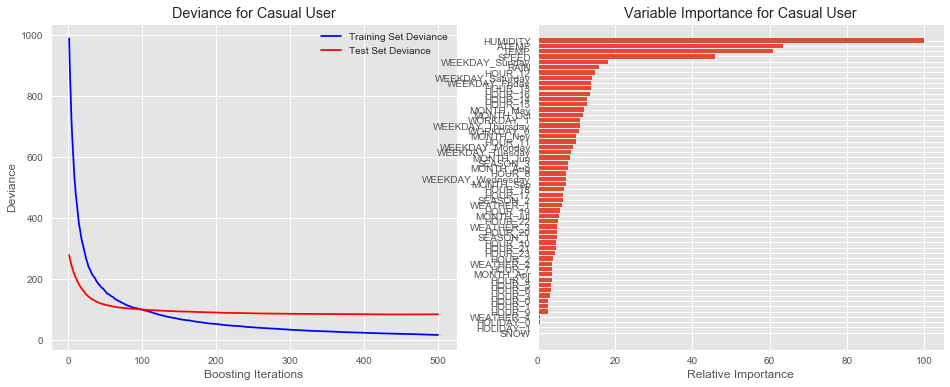

In [77]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gb_casual.staged_predict(X_test)):
    test_score[i] = gb_casual.loss_(y_test, y_pred)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance for Casual User')
plt.plot(np.arange(params['n_estimators']) + 1, gb_casual.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

feature_importance = gb_casual.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for Casual User')
plt.show()

In [78]:
#Find MSE on No Of Bike Rental prediction by casual user using 5 K-folds
kf = KFold(5, shuffle = True)
scores = cross_val_score(gb_casual, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 499.9114631383185 
SE: 51.03309353403633


##### Linear Regression Model - All User

In [79]:
X = dfRental
y = dfHourlyRental['TOTAL']

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Need to normalize due to wide variance between features
lm = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#Fit on training data
model = lm.fit(X_train, y_train)

#Look at coefficients of the model
print(pd.DataFrame(lm.coef_, index = X.columns, columns = ['estimatedCoefficients']))

                   estimatedCoefficients
TEMP                        6.860025e-02
ATEMP                       7.926594e-01
HUMIDITY                   -1.301275e-01
SPEED                      -3.160467e+00
RAIN                        1.978009e+00
SNOW                        8.279366e+16
SEASON_1                    8.285307e+14
SEASON_2                    8.285307e+14
SEASON_3                    8.285307e+14
HOUR_0                     -2.733553e+14
HOUR_1                     -2.733553e+14
HOUR_2                     -2.733553e+14
HOUR_3                     -2.733553e+14
HOUR_4                     -2.733553e+14
HOUR_5                     -2.733553e+14
HOUR_6                     -2.733553e+14
HOUR_7                     -2.733553e+14
HOUR_8                     -2.733553e+14
HOUR_9                     -2.733553e+14
HOUR_10                    -2.733553e+14
HOUR_11                    -2.733553e+14
HOUR_12                    -2.733553e+14
HOUR_13                    -2.733553e+14
HOUR_14         

In [81]:
lm_score = round(lm.score(X_test, y_test),2)

print('Test R2 on Bike Rental by all user using Linear Regression prediction {}'.format(lm_score))

Test R2 on Bike Rental by all user using Linear Regression prediction 0.63


In [82]:
print('MSE for training response data: {:.2f}'.format(np.mean((lm.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((lm.predict(X_test) - y_test) ** 2)))

MSE for training response data: 5756.49
MSE for test response data: 5714.19


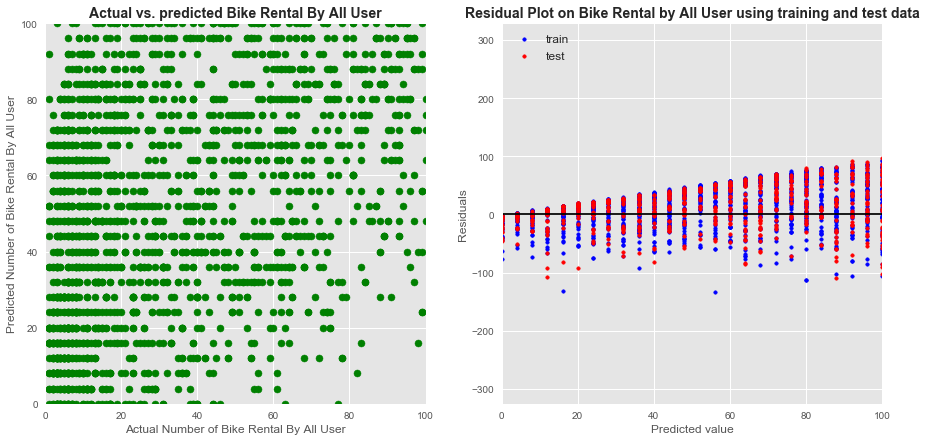

In [83]:
fig = plt.figure(figsize=(15,7))

#Plot actual vs. predicted on number of Bike Rental
plt.subplot(1,2,1)
plt.scatter(y, lm.predict(X), c='g');
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Actual Number of Bike Rental By All User', fontsize = 12);
plt.ylabel('Predicted Number of Bike Rental By All User', fontsize = 12);
plt.title('Actual vs. predicted Bike Rental By All User', fontsize = 14, fontweight = 'bold');

#Plot residuals of number of Bike Rental
plt.subplot(1,2,2)
plt.scatter(lm.predict(X_train), lm.predict(X_train) - y_train, c='b', marker = '.', label = 'train')
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=0, xmax = 100)
plt.title('Residual Plot on Bike Rental by All User using training and test data', fontsize = 14, fontweight = 'bold');
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,100]);
plt.legend(fontsize = 12, loc = 2)

plt.show()

In [84]:
#Using K-folds and cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle = True)
lm_casual_cv = LinearRegression(normalize = True)

#Find MSE on number of Bike Rental prediction
scores = cross_val_score(lm_casual_cv, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 5877.10 
SE: 341.43


##### Random Forest Model - All User

In [85]:
X = dfRental
y = dfHourlyRental['TOTAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [86]:
from sklearn.ensemble import RandomForestRegressor

rf_casual = RandomForestRegressor(random_state = 0)

rf_casual.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [87]:
casual_score = round(rf_casual.score(X_test, y_test),2)

print('Test R2 on demand for bike renal for all user using Random Forest prediction {}'.format(casual_score))

Test R2 on demand for bike renal for all user using Random Forest prediction 0.81


In [88]:
print('MSE for training response data: {:.2f}'.format(np.mean((rf_casual.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((rf_casual.predict(X_test) - y_test) ** 2)))

MSE for training response data: 659.69
MSE for test response data: 3338.04


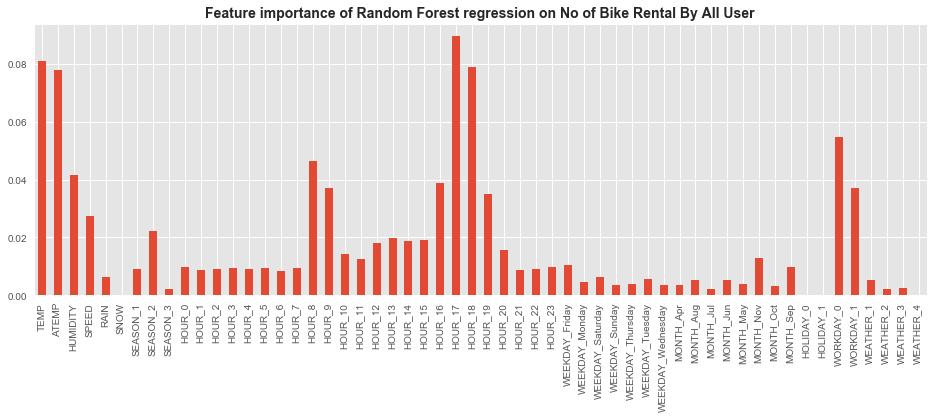

In [89]:
casual_features = pd.Series(rf_casual.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(16,5));
casual_features.plot(kind = 'bar');
plt.title('Feature importance of Random Forest regression on No of Bike Rental By All User', fontsize = 14, fontweight = 'bold');

In [90]:
#Find MSE on number of Bike Rental prediction using 5 K-folds for Casual User
kf = KFold(5, shuffle = True)
scores = cross_val_score(rf_casual, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 3711.932518508346 
SE: 330.8419514035939


##### Gradient Boosting Model - All User

In [91]:
X = dfRental
y = dfHourlyRental['TOTAL']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [92]:
import random
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 500, 'max_depth': 6,
        'learning_rate': 0.1, 'loss': 'huber','alpha':0.95}
gb_casual = GradientBoostingRegressor(**params).fit(X_train, y_train)

mse = mean_squared_error(y_test, gb_casual.predict(X_test))
r2 = r2_score(y_test, gb_casual.predict(X_test))

In [93]:
casual_score = round(gb_casual.score(X_test, y_test),2)

print('Test R2 on demand for bike rental by all user using Gradient Boosting prediction is {}'.format(casual_score))

Test R2 on demand for bike rental by all user using Gradient Boosting prediction is 0.86


In [94]:
print('MSE for training response data: {:.2f}'.format(np.mean((gb_casual.predict(X_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((gb_casual.predict(X_test) - y_test) ** 2)))

MSE for training response data: 342.64
MSE for test response data: 2411.35


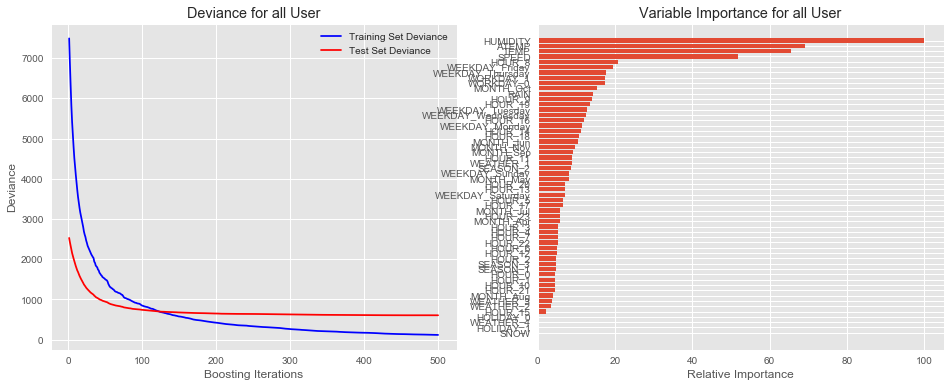

In [95]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gb_casual.staged_predict(X_test)):
    test_score[i] = gb_casual.loss_(y_test, y_pred)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance for all User')
plt.plot(np.arange(params['n_estimators']) + 1, gb_casual.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

feature_importance = gb_casual.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance for all User')
plt.show()

In [96]:
#Find MSE on No Of Bike Rental prediction by all user using 5 K-folds
kf = KFold(5, shuffle = True)
scores = cross_val_score(gb_casual, X_train, y_train, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 2900.611943047559 
SE: 207.0924972152222
